In [1]:
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder

In [2]:
def image_show(img, transform):
    plt.imshow(img.permute(1, 2, 0)  )
#     image = transform(img)
#     plt.imshow(image.permute(1, 2, 3))

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),
    transforms.RandomRotation(30),
])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [5]:
def train_val_split(dataset, split_size = 0.3):
    train_index, val_index = train_test_split(list(range(len(dataset))), test_size=split_size)
    datasets = {}
    datasets['train'] = Subset(dataset, train_index)
    datasets['val'] = Subset(dataset, val_index)
    return datasets

dataset = ImageFolder('dataset', transform=transform)
# To Print the total number of image files
print(len(dataset))
datasets = train_val_split(dataset)
# To Print only the number of training set image files
print(len(datasets['train']))
#To Print the total number of Validataion image files
print(len(dataset[1]))

print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x], 32, shuffle=True, num_workers=4) for x in ['train', 'val']}
x, y = next(iter(dataloaders['train']))


train_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(datasets['val'], batch_size=32, shuffle=False, num_workers=4)

train_x, train_y = next(iter(train_loader))

val_x, val_y = next(iter(val_loader))

print("Train and Val loaders shape")
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
#This gives output 32 color images of 200 x 200 px image size as x.shape and 32 class labels as y.shape
print(x.shape, y.shape)

67332
47132
2
Dataset ImageFolder
    Number of datapoints: 67332
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomInvert(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
Train and Val loaders shape
torch.Size([32, 3, 256, 256]) torch.Size([32])
torch.Size([32, 3, 256, 256]) torch.Size([32])
torch.Size([32, 3, 256, 256]) torch.Size([32])


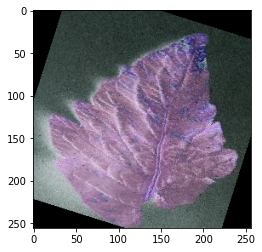

In [6]:
image_show(x[1], transform)

In [7]:
batch_size = 32
n_iters = 20000

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(8*64*64, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 8)
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [10]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [11]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=30
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [04:07<00:00,  5.96it/s]


Train Loss: 1.898 | Accuracy: 32.664


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:51<00:00,  5.68it/s]


Test Loss: 1.743 | Accuracy: 36.074

Epoch : 2


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [04:15<00:00,  5.75it/s]


Train Loss: 1.604 | Accuracy: 39.292


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [02:11<00:00,  4.81it/s]


Test Loss: 1.454 | Accuracy: 45.307

Epoch : 3


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [04:32<00:00,  5.40it/s]


Train Loss: 1.403 | Accuracy: 49.304


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:55<00:00,  5.48it/s]


Test Loss: 1.315 | Accuracy: 52.000

Epoch : 4


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:38<00:00,  6.75it/s]


Train Loss: 1.296 | Accuracy: 54.823


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:35<00:00,  6.64it/s]


Test Loss: 1.364 | Accuracy: 53.639

Epoch : 5


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:29<00:00,  7.02it/s]


Train Loss: 1.228 | Accuracy: 57.823


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:36<00:00,  6.57it/s]


Test Loss: 1.222 | Accuracy: 58.802

Epoch : 6


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:27<00:00,  7.09it/s]


Train Loss: 1.182 | Accuracy: 59.355


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:25<00:00,  7.36it/s]


Test Loss: 1.123 | Accuracy: 62.535

Epoch : 7


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:33<00:00,  6.89it/s]


Train Loss: 1.135 | Accuracy: 60.980


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:23<00:00,  7.56it/s]


Test Loss: 1.094 | Accuracy: 62.079

Epoch : 8


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:38<00:00,  6.74it/s]


Train Loss: 1.098 | Accuracy: 61.926


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:28<00:00,  7.11it/s]


Test Loss: 1.227 | Accuracy: 57.342

Epoch : 9


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:31<00:00,  6.98it/s]


Train Loss: 1.070 | Accuracy: 62.985


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [02:01<00:00,  5.22it/s]


Test Loss: 1.058 | Accuracy: 61.807

Epoch : 10


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:48<00:00,  6.45it/s]


Train Loss: 1.041 | Accuracy: 63.723


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:28<00:00,  7.17it/s]


Test Loss: 1.080 | Accuracy: 62.723

Epoch : 11


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:44<00:00,  6.55it/s]


Train Loss: 1.022 | Accuracy: 64.324


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:30<00:00,  6.96it/s]


Test Loss: 0.972 | Accuracy: 66.045

Epoch : 12


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:42<00:00,  6.61it/s]


Train Loss: 0.992 | Accuracy: 65.370


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:29<00:00,  7.09it/s]


Test Loss: 0.973 | Accuracy: 66.307

Epoch : 13


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:39<00:00,  6.70it/s]


Train Loss: 0.966 | Accuracy: 66.129


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:38<00:00,  6.45it/s]


Test Loss: 0.933 | Accuracy: 66.619

Epoch : 14


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:45<00:00,  6.52it/s]


Train Loss: 0.944 | Accuracy: 66.931


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:38<00:00,  6.42it/s]


Test Loss: 1.210 | Accuracy: 57.480

Epoch : 15


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:51<00:00,  6.35it/s]


Train Loss: 0.919 | Accuracy: 67.731


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:20<00:00,  7.82it/s]


Test Loss: 0.898 | Accuracy: 68.054

Epoch : 16


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:42<00:00,  6.62it/s]


Train Loss: 0.896 | Accuracy: 68.251


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:16<00:00,  8.31it/s]


Test Loss: 0.906 | Accuracy: 67.861

Epoch : 17


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:45<00:00,  6.54it/s]


Train Loss: 0.873 | Accuracy: 69.076


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:18<00:00,  8.07it/s]


Test Loss: 0.844 | Accuracy: 69.950

Epoch : 18


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.18it/s]


Train Loss: 0.850 | Accuracy: 69.380


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:08<00:00,  9.20it/s]


Test Loss: 0.824 | Accuracy: 70.421

Epoch : 19


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.18it/s]


Train Loss: 0.837 | Accuracy: 69.749


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:08<00:00,  9.29it/s]


Test Loss: 0.868 | Accuracy: 69.198

Epoch : 20


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.16it/s]


Train Loss: 0.816 | Accuracy: 70.667


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:06<00:00,  9.54it/s]


Test Loss: 0.863 | Accuracy: 68.970

Epoch : 21


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:29<00:00,  7.03it/s]


Train Loss: 0.798 | Accuracy: 71.160


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:07<00:00,  9.43it/s]


Test Loss: 0.789 | Accuracy: 71.827

Epoch : 22


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:24<00:00,  7.21it/s]


Train Loss: 0.787 | Accuracy: 71.660


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:09<00:00,  9.13it/s]


Test Loss: 0.812 | Accuracy: 70.416

Epoch : 23


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.16it/s]


Train Loss: 0.771 | Accuracy: 72.293


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:08<00:00,  9.21it/s]


Test Loss: 0.730 | Accuracy: 73.881

Epoch : 24


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.16it/s]


Train Loss: 0.747 | Accuracy: 73.016


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:11<00:00,  8.87it/s]


Test Loss: 0.721 | Accuracy: 74.381

Epoch : 25


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:27<00:00,  7.11it/s]


Train Loss: 0.732 | Accuracy: 73.818


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:07<00:00,  9.41it/s]


Test Loss: 0.768 | Accuracy: 72.757

Epoch : 26


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:23<00:00,  7.22it/s]


Train Loss: 0.719 | Accuracy: 74.438


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:09<00:00,  9.11it/s]


Test Loss: 0.707 | Accuracy: 74.946

Epoch : 27


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:30<00:00,  7.01it/s]


Train Loss: 0.710 | Accuracy: 74.537


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:28<00:00,  7.13it/s]


Test Loss: 0.724 | Accuracy: 73.446

Epoch : 28


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:27<00:00,  7.08it/s]


Train Loss: 0.701 | Accuracy: 74.784


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:08<00:00,  9.20it/s]


Test Loss: 0.667 | Accuracy: 76.243

Epoch : 29


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:25<00:00,  7.17it/s]


Train Loss: 0.689 | Accuracy: 75.231


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:06<00:00,  9.49it/s]


Test Loss: 0.704 | Accuracy: 74.752

Epoch : 30


100%|██████████████████████████████████████████████████████████████████████████████| 1473/1473 [03:26<00:00,  7.15it/s]


Train Loss: 0.678 | Accuracy: 75.747


100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [01:09<00:00,  9.08it/s]


Test Loss: 0.756 | Accuracy: 72.545


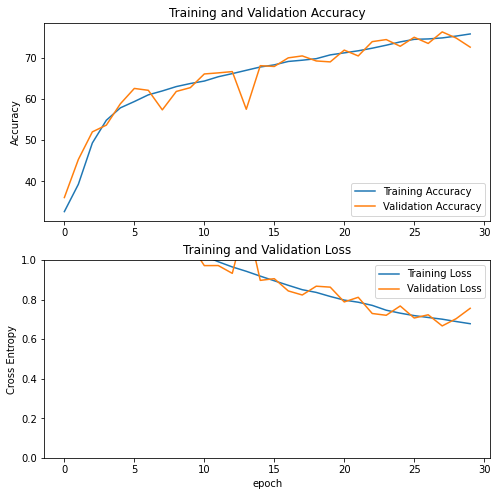

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()